# Notes

This experiment shows a reproduction of paper results from the link below, as well as some extention trying to improve the results using bootstrapping and Adaboost.
http://stanford.edu/~boyd/papers/pdf/pareto_opt_class_long.pdf

This experiment is heavily based on the package 'ece602_project' that I (20576707) and my previous team mate Sunsheng Gu (20556710) wrote. I am going to explain how we construct the package, what has been done by me and Sunsheng before the change of paper project, as well as what I have modified individually for the individual final project.

`ece602_project`:
- `tradeoff_analysis`: main file containing all the problem formulation and solution
    - `opt_linear`: a parent object containing common methods for all linear solvers
        - `opt_linear_AB`: fist optimization problem that solves `eqn 3` in the paper, based on opt_linear 
        - `opt_linear_01toA`: second optimization problem that solves `eqn 4` in the paper, based on opt_linear
        - `opt_linear_Bto10`: third optimization problem that solves `eqn 5` in the paper, based on opt_linear
        - `opt_linear_kernel`: fourth optimization probelm that solves `eqn 13` in the paper, based on opt_linear
    - `bootstrap_opt_linear`: a bootstrapping wrapper for above linear solvers
    - `boosted_opt_linear`: a adaboost wrapper for linear solver `opt_linear_AB` ONLY
- `utils`: common utility functions that are used within tradeoff_analysis

During the paper project phase (work as a 2-person team), I primarily constructed the package `ece602_project` including problem formulation using CVXPY and SciPy, and package structure formulation and writting. Sunsheng primarily reviewed, fixed, and tested the code along with documentation of the paper. `opt_linaer` and its child objects are all done during this phase.

During the individual phase, I created the `bootstrap_opt_linear` and `boosted_opt_linear` wrapper. I also modified the `opt_linear` and its child objects to make things compatible with bootstrapping and Adaboost algorithms.

In [1]:
# packages
%pylab inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output

# own functions
from ece602_project.tradeoff_analysis import opt_linear_AtoB, opt_linear_01toA, \
opt_linear_Bto10, opt_linear_kernel, bootstrap_opt_linear, boosted_opt_linear
from ece602_project.utils import evaluate

Populating the interactive namespace from numpy and matplotlib


# Prepare Data

Note that this data set is `unbalanced` meaning the positive cases are much more than negative cases.

In [2]:
data = pd.read_table('ionosphere/ionosphere.data', delimiter=',', header=None)
X = np.array(data.loc[:,0:33])
y = np.array(data.loc[:,34].replace('g',1).replace('b',-1)) # -1 is bad, 1 is good

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=200)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Positive cases:',sum(y==1),'Negative cases:',sum(y==-1))

X_train shape: (245, 34)
y_train shape: (245,)
X_test shape: (106, 34)
y_test shape: (106,)
Positive cases: 225 Negative cases: 126


# Optimization between A and B

This optimization problem assumes that both true-positive rate and true-negative rate are greater than 0.5:
$$Pr(a^Tx<b|y=-1) \geqslant 0.5$$
$$Pr(a^Tx>b|y=+1) \geqslant 0.5$$

By assuming Gaussian distribution of the data, this problem can be formulated into a sonstrained optimization problem:
$$\underset{a}{argmin}\sqrt{a^T\Sigma_+a}+\lambda\sqrt{a^T\Sigma_-a}$$
$$s.t. a^T(\mu_+-\mu_-)=1$$

Note that two square roots can be formulated as norms by taking matrix square roots of the covariance matrix:
$$\underset{a}{argmin} \; ||Q_+a||_2+\lambda||Q_-a||_2$$
$$s.t. a^T(\mu_+-\mu_-)=1$$
$$where \; Q_+^TQ_+=\Sigma_+ \;\;\;\; Q_-^TQ_-=\Sigma_- $$

This new problem can be solved efficiently via convex optimization using CVXPY

In [3]:
def opt_AB(X_train, X_test, y_train, y_test):
    tp_AB = []
    tn_AB = []
    for i in np.arange(0,9.21,0.2): # test values between 0.01 to 100 between two terms
        clear_output(wait=True)
        a = opt_linear_AtoB()
        a.prepare(X_train, y_train)
        a.compile(λ=0.01*np.exp(i))
        a.solve(verbose=False)
        y_pred = a.predict(X_test)
        results = evaluate(y_test, y_pred, verbose=True)
        tn_AB.append(results[1,0])
        tp_AB.append(results[1,3])
        print('progress:{:.2%}'.format(i/9.21))
    clear_output(wait=True)
    print('Done')
    return tp_AB, tn_AB

# Optimization between 01 and A

This optimization problem assumes that true-negative rate is between 0 and 0.5:
$$Pr(a^Tx<b|y=-1) \in (0,0.5)$$

Then the optimization problem becomes to:
$$\underset{a}{argmax}\; Pr(a^Tx>b|y=+1)$$
$$s.t. Pr(a^Tx<b|y=-1)=\alpha, \;\alpha\in(0,0.5)$$

By assuming Gaussian distribution of the data:
$$\underset{a}{argmin}\;\left(-\frac{a^T\mu_+-b}{\sqrt{a^T\Sigma_+a}}\right)$$
$$s.t. \Phi\left( \frac{b-a^T\mu_-}{\sqrt{a^T\Sigma_-a}} \right)-\alpha=0$$

where $\Phi$ is the cdf of standard normal distribution.
Note that there are a few changes comparing to the eqn 4 in the paper:
- $\beta$ in the objective function is replaced by the fraction inside $\Phi$ due to monotonic increase of the cdf
- maximize was changed to minimize to be compatible with SciPy

This is the exact problem that is solved by SciPy constrained obtimization. I coould not formulate this problem into the CVX compatible form since this is a maximization problem of a convex function with constraints (shown in eqn 21 in the paper)

In [4]:
def opt_01A(X_train, X_test, y_train, y_test):
    tp_01A = []
    tn_01A = []
    for i in np.arange(0.01,0.5,0.1): # try α between 0.01 and 0.5
        clear_output(wait=True)
        a = opt_linear_01toA()
        a.prepare(X_train, y_train)
        a.compile(α=i)
        a.solve();
        y_pred = a.predict(X_test)
        results = evaluate(y_test, y_pred, verbose=True)
        tn_01A.append(results[1,0])
        tp_01A.append(results[1,3])
        print('progress:{:.2%}'.format((i-0.01)/(0.5-0.01)))
    clear_output(wait=True)
    print('Done')
    return tp_01A, tn_01A

# Optimization between B and 10

This optimization problem is exactly the same as the previous problem but with opposite objective and constraints.

$$\underset{a}{argmax}\; Pr(a^Tx<b|y=-1)$$
$$s.t. Pr(a^T>b|y=+1)=\beta, \;\beta\in(0,0.5)$$

By assuming Gaussian distribution of the data:
$$\underset{a}{argmin}\;\left(-\frac{b-a^T\mu_-}{\sqrt{a^T\Sigma_-a}}\right)$$
$$s.t. \Phi\left( \frac{a^T\mu_+-b}{\sqrt{a^T\Sigma_+a}} \right)-\beta=0$$

In [5]:
def opt_B10(X_train, X_test, y_train, y_test):
    tp_B10 = []
    tn_B10 = []
    for i in np.arange(0.01,0.5,0.1):  # try β between 0.01 and 0.5
        clear_output(wait=True)
        a = opt_linear_Bto10()
        a.prepare(X_train, y_train)
        a.compile(β=i)
        a.solve();
        y_pred = a.predict(X_test)
        results = evaluate(y_test, y_pred, verbose=True)
        tn_B10.append(results[1,0])
        tp_B10.append(results[1,3])
        print('progress:{:.2%}'.format((i-0.01)/(0.5-0.01)))
    clear_output(wait=True)
    print('Done')
    return tp_B10, tn_B10

# kernel Method

The kernel method of solving the optimization problem shown in eqn 3 is described in eqn 13.

The formulation of the problem is similar to that of eqn 3 but with alternative 'covariance matrix' and 'mean'. 
$$\underset{\alpha}{argmin}\sqrt{\alpha^TF_+\alpha}+\lambda\sqrt{\alpha^TF_-\alpha}$$
$$s.t. \alpha^TG(g_+-g_-)=1$$
where equations for $G, g, F$ can be found in eqn 13

Similarly, two square roots can be formulated as norms by taking matrix square roots of the covariance matrix:
$$\underset{\alpha}{argmin} \; ||P_+\alpha||_2+\lambda||P_-\alpha||_2$$
$$s.t. \alpha^TG(g_+-g_-)=1$$
$$where \; P_+^TP_+=F_+ \;\;\;\;\; P_-^TP_-=F_- $$

In [ ]:
def opt_ker(X_train, X_test, y_train, y_test):
    tp_ker = []
    tn_ker = []
    for i in np.arange(0,9.21,0.4): # test values between 0.05 to 20 between two terms
        clear_output(wait=True)
        a = opt_linear_kernel()
        a.prepare(X_train, y_train)
        a.compile(λ=0.05*np.exp(i))
        a.solve(verbose=False)
        y_pred = a.predict(X_test)
        results = evaluate(y_test, y_pred, verbose=True)
        tn_ker.append(results[1,0])
        tp_ker.append(results[1,3])
        print('progress:{:.2%}'.format(i/9.21))
    clear_output(wait=True)
    print('Done')
    return tp_ker, tn_ker

# Bootstrapping & Bagging

The idea of bootstrapping and bagging comes from the paper from Breiman in 1996.https://link.springer.com/content/pdf/10.1023/A:1018054314350.pdf

The idea of bagging is to generate multiple predictors based on bootstrapped data set (subset of the original data using sample with replacement). The final prediction is then generated by taking the average of all predictors. 

Bagging can increase predictor accuracy if the nature of data is sensitive to perturbation. In another word, if changing the data set can change the predictor significantly, then bagging can effectively increase prediction accuracy.

To implement bagging, the following procedue is computed:

Input: 
- sequence of labeled data $<(x_1,y_1), ..., (x_n,y_n)>$
- weak predictor (e.g. opt_linear_AB)
- integer $T$ specifying number of weak predictors to be generated

Do for $t = 1,2,...,T$:
- create a weak predictor
- generate a sub-data set
- solve corresponding optimization problem
- store obtained pareto optimal classifier parameters

for prediction:
- Do for $t = 1,2,...,T$:
    - generate predictions using $t$th classifier
- average all predictions in the end

In [7]:
def opt_AB_strap(X_train, X_test, y_train, y_test, size=0.5, T=10, sparse_ratio=0.5):
    import cvxpy as cp
    tp_bootstrap = []
    tn_bootstrap = []
    for i in np.arange(0,9.21,0.4): # test values between 0.05 to 20 between two terms
        clear_output(wait=True)
        a = bootstrap_opt_linear(X_train, y_train, opt_linear_AtoB, T=T)
        a.prepare(size=size)
        a.compile(λ=0.01*np.exp(i), sparse_ratio=sparse_ratio)
        a.solve(verbose=False)
        y_pred = a.predict(X_test)
        results = evaluate(y_test, y_pred, verbose=True)
        tn_bootstrap.append(results[1,0])
        tp_bootstrap.append(results[1,3])
        print('progress:{:.2%}'.format(i/9.21))
    clear_output(wait=True)
    print('Done')
    return tp_bootstrap, tn_bootstrap

In [41]:
def opt_ker_strap(X_train, X_test, y_train, y_test, size=0.5, T=10):
    tp_bootstrap_ker = []
    tn_bootstrap_ker = []
    for i in np.arange(2.5,4.5,0.2): # test values between 0.05 to 20 between two terms
        clear_output(wait=True)
        a = bootstrap_opt_linear(X_train, y_train, opt_linear_kernel, T=T)
        a.prepare(size=size)
        a.compile(λ=0.05*np.exp(i))
        a.solve(verbose=False)
        y_pred = a.predict(X_test)
        results = evaluate(y_test, y_pred, verbose=True)
        tn_bootstrap_ker.append(results[1,0])
        tp_bootstrap_ker.append(results[1,3])
        print('progress:{:.2%}'.format((i-2.5)/2))
    clear_output(wait=True)
    print('Done')
    return tp_bootstrap_ker, tn_bootstrap_ker

# Adaboost

The idea of boosting originated back in 1990's from Schapire et. al.
https://www.face-rec.org/algorithms/Boosting-Ensemble/decision-theoretic_generalization.pdf
https://cseweb.ucsd.edu/~yfreund/papers/IntroToBoosting.pdf

Similar to bagging, boosting also generates many weak predictors. Through the power of boosting, the results from all the weak predictors are combined to create a strong predictors.

Adaboost, one of the boosting algorithm, modifies sample weights for the next weak predictor based on the mistakes that previous weak predictor makes. Therefore, each weak classifier is good at classifying some samples. Through the power of majority, the aggregated final classification accuracy is generally much higher than the results from individual predictors.

The algorithm that is adapted here is from the the book `Elements of Statistal learning` pg 339.https://web.stanford.edu/~hastie/Papers/ESLII.pdf

Procedue:

Input: 
- sequence of labeled data $<(x_1,y_1), ..., (x_n,y_n)>$
- weak learner (i.e. opt_linear_AB)
- integer $T$ specifying number of weak learners to be generated
- float $\lambda$ specifying the tradeoff between true positive and true negative (larger \lambda favors true negative)
- float $lr$ specifying the learning rate

Initialize:
- weight vector $w^1$ with dimension $n$

Do for $t = 1,2,...,T$:
- normalize weight vector

$$p^t = \frac{w^t}{\sum^{n}_{i=1}{w^t_i}} $$

- compute weighted mean and covaraince matrix for positive and negative cases $\mu_+, \mu_-, \sum_+, \sum_-$ with weights $p^t$
- obtain optimal linear classifier on weighted data via optimization
- compute prediction 

$$\hat{y}^t \rightarrow [-1,1]$$

- compute error of prediction where $1/2$ is to allow prediction to be $[-1,1]$ instead of $[0,1]$ 

$$\epsilon_t = \frac{1}{2}\sum^{n}_{i=1}{p^t_i|\hat{y}^t_i-y_i|}$$

- compute 

$$\beta_t=lr\;ln\left(\frac{1-\epsilon_t}{\epsilon_t}\right)$$

- update new weight vectors where $\mathcal{I}$ is a indication function that returns `1` when the statement is `True` and returns `0` when the statement is `False`: 

$$\gamma_t = 
\mathcal{I}\left(\frac{1}{2}(\hat{y}^t-y^t)<0\right)
\left(\frac{1}{1+\lambda}\right)+
\mathcal{I}\left(\frac{1}{2}(\hat{y}^t-y^t)>0\right)
\left(\frac{\lambda}{1+\lambda}\right)$$

$$w^{t+1}_i \leftarrow w^t_i exp\left(\beta_t\gamma_t\right)$$

for prediction:

$$\hat{y} = sign\left(\sum_{t=1}^T{\beta_t y_t}\right)$$

The `innovation` here is to modify the weight update function to include parameter $\lambda$. The venilla version of Adaboost updates weights only based on the prediction correctness. This will cause conflict against the Pareto optimal linear classifier as we have a specific target about true positive and true negative rates. For example, when $\lambda$ is small, we favor true positive over true negative. In another word, we want to correct false negative and ignore false positive. However, the Adaboost algorithm doesn't know this information and constantly trying to increase the weights for false positive and false negative equally which will break the pareto optimal condition. With the new update rule, we includes the information of $\lambda$ so that the adaboost algorithm adapts to what the pareto optimal condition wants.

One more `innovation` here is to reformulate the optimization problem to encourage predictor sparsity. Based on experience, Adaboost works well with weak classifiers such as decision stump or one-layer decision tree. If the classifier is too strong, the sample weight update will change too significantly, thus fails the boosting procedure in practice. To make the original optimization problem sparse, I added one more constraint:

$$\underset{a}{argmin}\sqrt{a^T\Sigma_+a}+\lambda\sqrt{a^T\Sigma_-a}$$

$$s.t. a^T(\mu_+-\mu_-)=1$$

$$a^Tdiag(\mathcal{V})=0$$

where $\mathcal{V}$ is the indication vector that contains $0$ or $1$. The index of value $1$s indicates that the corresbonding weights are 0. By randomly specifying the percentage and position of value $1$s, I can effectively restrictly the model representation capability and make it weaker.

Note: the kernel version of Adaboost is not implemented due to the fact that no existing evidence of computing weighted kernel matrix.

In [9]:
def opt_linear_adaboost(X_train, X_test, y_train, y_test, T=10, lr=1, sparse_ratio=0.5):
    tp_adaboost = []
    tn_adaboost = []
    for i in np.arange(0,9.21,0.4): # test values between 0.05 to 20 between two terms
        clear_output(wait=True)
        a = boosted_opt_linear(X_train, y_train, T=T, sparse_ratio=sparse_ratio, lr=lr, λ=0.01*np.exp(i))
        a.solve()
        y_pred = a.predict(X_test)
        results = evaluate(y_test, y_pred, verbose=True)
        tn_adaboost.append(results[1,0])
        tp_adaboost.append(results[1,3])
        print('progress:{:.2%}'.format(i/9.21))
    clear_output(wait=True)
    print('Done')
    return tp_adaboost, tn_adaboost

# Plot the results 

The final results are generated by averaging 20 experimental trials. 70% of the data is used for training, and 30% are used for testing. Random seeds are fixed during the experiments to ensure reproducibility.

In [87]:
tp_AB_total = []
tp_01A_total = []
tp_B10_total = []
tn_AB_total = []
tn_01A_total = []
tn_B10_total = []
tp_ker_total = []
tn_ker_total = []
tp_bootstrap_total = []
tn_bootstrap_total = []
tp_bootstrap_ker_total = []
tn_bootstrap_ker_total = []
tp_adaboost_total = []
tn_adaboost_total = []

In [88]:
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i*2)
    
    tp_AB, tn_AB = opt_AB(X_train, X_test, y_train, y_test)
    tp_AB_total.append(tp_AB)
    tn_AB_total.append(tn_AB)
    
    tp_01A, tn_01A = opt_01A(X_train, X_test, y_train, y_test)
    tp_01A_total.append(tp_01A)
    tn_01A_total.append(tn_01A)
    
    tp_B10, tn_B10 = opt_B10(X_train, X_test, y_train, y_test)
    tp_B10_total.append(tp_B10)
    tn_B10_total.append(tn_B10)
    
    tp_ker, tn_ker = opt_ker(X_train, X_test, y_train, y_test)
    tp_ker_total.append(tp_ker)
    tn_ker_total.append(tn_ker)
    
    tp_bootstrap, tn_bootstrap = opt_AB_strap(X_train, X_test, y_train, y_test, size=0.5, T=17, sparse_ratio=0.5)
    tp_bootstrap_total.append(tp_bootstrap)
    tn_bootstrap_total.append(tn_bootstrap)
    
    tp_bootstrap_ker, tn_bootstrap_ker = opt_ker_strap(X_train, X_test, y_train, y_test, size=0.3, T=13)
    tp_bootstrap_ker_total.append(tp_bootstrap_ker)
    tn_bootstrap_ker_total.append(tn_bootstrap_ker)
    
    tp_adaboost, tn_adaboost = opt_linear_adaboost(X_train, X_test, y_train, y_test, T=21, lr=0.5, sparse_ratio=0.5)
    tp_adaboost_total.append(tp_adaboost)
    tn_adaboost_total.append(tn_adaboost)

Done


In [89]:
tp_AB_avg = np.average(np.array(tp_AB_total), axis=0)
tn_AB_avg = np.average(np.array(tn_AB_total), axis=0)
tp_01A_avg = np.average(np.array(tp_01A_total), axis=0)
tn_01A_avg = np.average(np.array(tn_01A_total), axis=0)
tp_B10_avg = np.average(np.array(tp_B10_total), axis=0)
tn_B10_avg = np.average(np.array(tn_B10_total), axis=0)
tp_ker_avg = np.average(np.array(tp_ker_total), axis=0)
tn_ker_avg = np.average(np.array(tn_ker_total), axis=0)
tp_bootstrap_avg = np.average(np.array(tp_bootstrap_total), axis=0)
tn_bootstrap_avg = np.average(np.array(tn_bootstrap_total), axis=0)
tp_bootstrap_ker_avg = np.average(np.array(tp_bootstrap_ker_total), axis=0)
tn_bootstrap_ker_avg = np.average(np.array(tn_bootstrap_ker_total), axis=0)
tp_adaboost_avg = np.average(np.array(tp_adaboost_total), axis=0)
tn_adaboost_avg = np.average(np.array(tn_adaboost_total), axis=0)

## Reproduction of The Paper Results (Figure 3)

Text(0, 0.5, 'true positive rate')

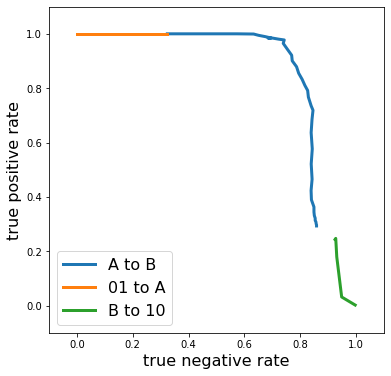

In [90]:
figure(figsize=(6,6))
xlim(-0.1,1.1)
ylim(-0.1,1.1)
plot(tn_AB_avg, tp_AB_avg,linewidth=3)
plot(tn_01A_avg, tp_01A_avg, linewidth=3)
plot(tn_B10_avg, tp_B10_avg, linewidth=3)
legend(['A to B','01 to A','B to 10'],fontsize=16)
xlabel('true negative rate',fontsize=16)
ylabel('true positive rate',fontsize=16)

The results from solving eqn 3,4,5 generates very compelling graph comparing to Figure 3 in the paper. The only difference between my results vs the paper results is that the accuracy for both true positive and true negative are higher than what's in the paper. One hypothesis may be due to increased accuracy withing the convex optimization solver.

Text(0, 0.5, 'true positive rate')

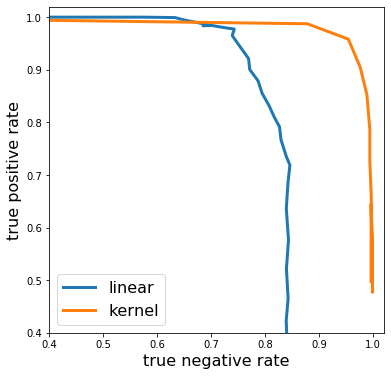

In [91]:
figure(figsize=(6,6))
xlim(0.4,1.02)
ylim(0.4,1.02)
plot(tn_AB_avg, tp_AB_avg, linewidth=3)
plot(tn_ker_avg, tp_ker_avg, linewidth=3)
legend(['linear','kernel'],fontsize=16)
xlabel('true negative rate',fontsize=16)
ylabel('true positive rate',fontsize=16)

By comparing the kernel method and linear method, kernel yields much higher accuracy, thus push the pareto optimal boundary to the upright corner.

Text(0, 0.5, 'true positive rate')

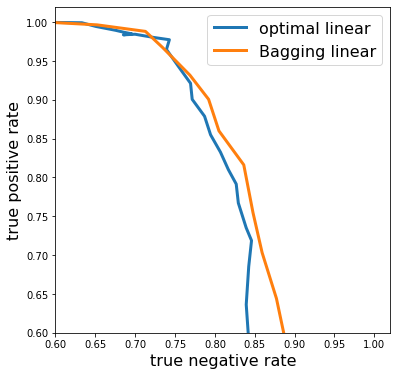

In [100]:
figure(figsize=(6,6))
xlim(0.6,1.02)
ylim(0.6,1.02)
plot(tn_AB_avg, tp_AB_avg, linewidth=3)
plot(tn_bootstrap_avg, tp_bootstrap_avg, linewidth=3)
legend(['optimal linear','Bagging linear'],fontsize=16)
xlabel('true negative rate',fontsize=16)
ylabel('true positive rate',fontsize=16)

By comparing bagging and regular linear predictor, the performance is very similar, indicating the dataset is not very sensitive to perturbation.

Text(0, 0.5, 'true positive rate')

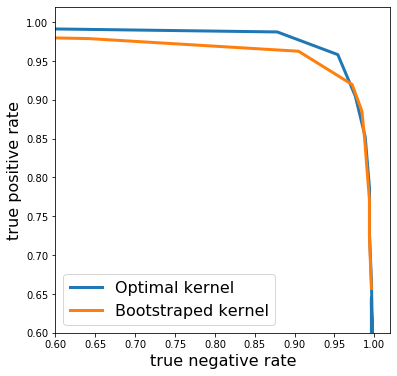

In [101]:
figure(figsize=(6,6))
xlim(0.6,1.02)
ylim(0.6,1.02)
plot(tn_ker_avg, tp_ker_avg, linewidth=3)
plot(tn_bootstrap_ker_avg, tp_bootstrap_ker_avg, linewidth=3)
legend(['Optimal kernel','Bootstraped kernel'],fontsize=16)
xlabel('true negative rate',fontsize=16)
ylabel('true positive rate',fontsize=16)

By comparing bagging kernel and regular kernel predictor, the performance is again very similar, indicating the dataset is not very sensitive to perturbation.

Text(0, 0.5, 'true positive rate')

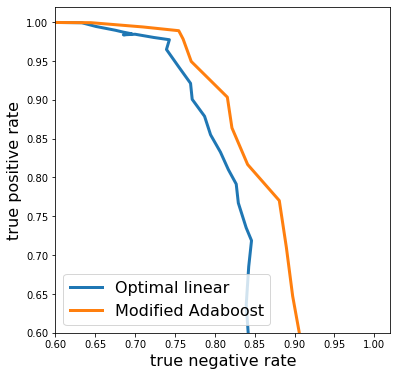

In [102]:
figure(figsize=(6,6))
xlim(0.6,1.02)
ylim(0.6,1.02)
plot(tn_AB_avg, tp_AB_avg,linewidth=3)
plot(tn_adaboost_avg, tp_adaboost_avg, linewidth=3)
legend(['Optimal linear','Modified Adaboost'],fontsize=16)
xlabel('true negative rate',fontsize=16)
ylabel('true positive rate',fontsize=16)

By comparing the Adaboost linear and regular linear predictor, the adaboost linear predictor performs much better at bottom right region. Note that this data set is unbalanced. By adaptively changing the sample weights, adaboost linear predictor outperforms the regular linear classifier at minority class, which is negative samples in this case.

# The following sections showed how hyperparamters are determined

# Bagging Hyperparameter Search

### Vary T

In [10]:
tp_bagging = []
tn_bagging = []

for t in np.arange(1,22,4):
    tp_bagging_tmp = []
    tn_bagging_tmp = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        tp, tn = opt_AB_strap(X_train, X_test, y_train, y_test, size=0.5, T=t, sparse_ratio=0.5)
        tp_bagging_tmp.append(tp)
        tn_bagging_tmp.append(tn)
    tp_bagging_tmp_avg = np.average(np.array(tp_bagging_tmp), axis=0)
    tn_bagging_tmp_avg = np.average(np.array(tn_bagging_tmp), axis=0)
    tp_bagging.append(tp_bagging_tmp_avg)
    tn_bagging.append(tn_bagging_tmp_avg)

Done


Text(0, 0.5, 'true positive rate')

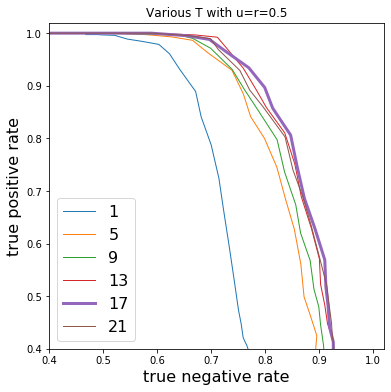

In [15]:
figure(figsize=(6,6))
xlim(0.4,1.02)
ylim(0.4,1.02)
# plot(tn_AB_avg, tp_AB_avg,linewidth=3)
plot(tn_bagging[0], tp_bagging[0],linewidth=1)
plot(tn_bagging[1], tp_bagging[1],linewidth=1)
plot(tn_bagging[2], tp_bagging[2],linewidth=1)
plot(tn_bagging[3], tp_bagging[3],linewidth=1)
plot(tn_bagging[4], tp_bagging[4],linewidth=3)
plot(tn_bagging[5], tp_bagging[5],linewidth=1)
legend(['1','5','9','13','17','21'],fontsize=16)
title("Various T with u=r=0.5")
xlabel('true negative rate',fontsize=16)
ylabel('true positive rate',fontsize=16)

Choose T=17

### Vary sparse_ratio u

In [16]:
tp_bagging = []
tn_bagging = []

for u in np.arange(0.1,1.0,0.2):
    tp_bagging_tmp = []
    tn_bagging_tmp = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        tp, tn = opt_AB_strap(X_train, X_test, y_train, y_test, size=0.5, T=17, sparse_ratio=u)
        tp_bagging_tmp.append(tp)
        tn_bagging_tmp.append(tn)
    tp_bagging_tmp_avg = np.average(np.array(tp_bagging_tmp), axis=0)
    tn_bagging_tmp_avg = np.average(np.array(tn_bagging_tmp), axis=0)
    tp_bagging.append(tp_bagging_tmp_avg)
    tn_bagging.append(tn_bagging_tmp_avg)

Done


Text(0.5, 1.0, 'Various sparse_ratio u with r=0.5, T=17')

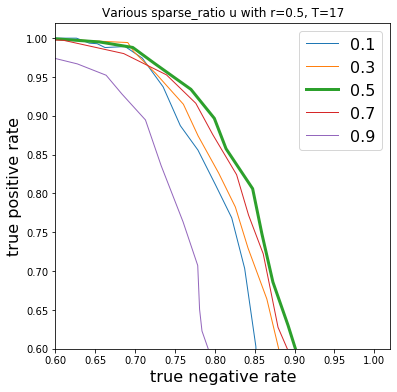

In [18]:
figure(figsize=(6,6))
xlim(0.6,1.02)
ylim(0.6,1.02)
# plot(tn_AB_avg, tp_AB_avg,linewidth=3)
plot(tn_bagging[0], tp_bagging[0],linewidth=1)
plot(tn_bagging[1], tp_bagging[1],linewidth=1)
plot(tn_bagging[2], tp_bagging[2],linewidth=3)
plot(tn_bagging[3], tp_bagging[3],linewidth=1)
plot(tn_bagging[4], tp_bagging[4],linewidth=1)
legend(['0.1','0.3','0.5','0.7','0.9'],fontsize=16)
xlabel('true negative rate',fontsize=16)
ylabel('true positive rate',fontsize=16)
title("Various sparse_ratio u with r=0.5, T=17")

Choose sparsity rate u = 0.5

### Reduce sample size r

In [19]:
tp_bagging = []
tn_bagging = []

for r in np.arange(0.2,0.6,0.1):
    tp_bagging_tmp = []
    tn_bagging_tmp = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        tp, tn = opt_AB_strap(X_train, X_test, y_train, y_test, size=r, T=17, sparse_ratio=0.5)
        tp_bagging_tmp.append(tp)
        tn_bagging_tmp.append(tn)
    tp_bagging_tmp_avg = np.average(np.array(tp_bagging_tmp), axis=0)
    tn_bagging_tmp_avg = np.average(np.array(tn_bagging_tmp), axis=0)
    tp_bagging.append(tp_bagging_tmp_avg)
    tn_bagging.append(tn_bagging_tmp_avg)

Done


Text(0.5, 1.0, 'Various sample set size r with u=0.5, T=17')

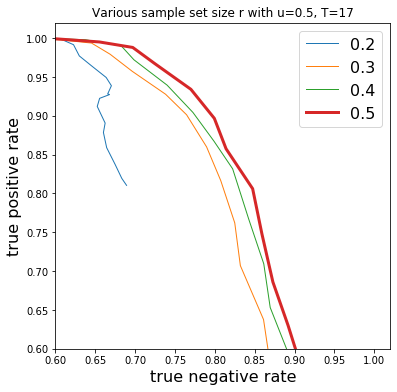

In [22]:
figure(figsize=(6,6))
xlim(0.6,1.02)
ylim(0.6,1.02)
plot(tn_bagging[0], tp_bagging[0],linewidth=1)
plot(tn_bagging[1], tp_bagging[1],linewidth=1)
plot(tn_bagging[2], tp_bagging[2],linewidth=1)
plot(tn_bagging[3], tp_bagging[3],linewidth=3)
legend(['0.2','0.3','0.4','0.5'],fontsize=16)
xlabel('true negative rate',fontsize=16)
ylabel('true positive rate',fontsize=16)
title("Various sample set size r with u=0.5, T=17")

choose r = 0.5

# Kernel Hyperparameter Search

In [44]:
tp_bagging_kernel = []
tn_bagging_kernel = []

for r in np.arange(0.1,0.6,0.1):
    tp_bagging_kernel_tmp = []
    tn_bagging_kernel_tmp = []
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        tp, tn = opt_ker_strap(X_train, X_test, y_train, y_test, size=r, T=5)
        tp_bagging_kernel_tmp.append(tp)
        tn_bagging_kernel_tmp.append(tn)
    tp_bagging_kernel_tmp_avg = np.average(np.array(tp_bagging_kernel_tmp), axis=0)
    tn_bagging_kernel_tmp_avg = np.average(np.array(tn_bagging_kernel_tmp), axis=0)
    tp_bagging_kernel.append(tp_bagging_kernel_tmp_avg)
    tn_bagging_kernel.append(tn_bagging_kernel_tmp_avg)

Done


Text(0.5, 1.0, 'Various sample set size r with T=5')

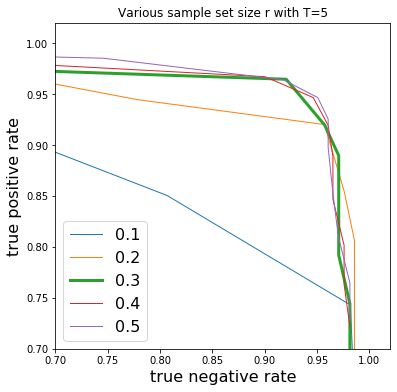

In [50]:
figure(figsize=(6,6))
xlim(0.7,1.02)
ylim(0.7,1.02)
# plot(tn_AB_avg, tp_AB_avg,linewidth=3)
plot(tn_bagging_kernel[0], tp_bagging_kernel[0],linewidth=1)
plot(tn_bagging_kernel[1], tp_bagging_kernel[1],linewidth=1)
plot(tn_bagging_kernel[2], tp_bagging_kernel[2],linewidth=3)
plot(tn_bagging_kernel[3], tp_bagging_kernel[3],linewidth=1)
plot(tn_bagging_kernel[4], tp_bagging_kernel[4],linewidth=1)
legend(['0.1','0.2','0.3','0.4','0.5'],fontsize=16)
xlabel('true negative rate',fontsize=16)
ylabel('true positive rate',fontsize=16)
title("Various sample set size r with T=5")

choose r = 0.3

In [51]:
tp_bagging_kernel = []
tn_bagging_kernel = []

for t in np.arange(1,18,4):
    tp_bagging_kernel_tmp = []
    tn_bagging_kernel_tmp = []
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        tp, tn = opt_ker_strap(X_train, X_test, y_train, y_test, size=0.3, T=t)
        tp_bagging_kernel_tmp.append(tp)
        tn_bagging_kernel_tmp.append(tn)
    tp_bagging_kernel_tmp_avg = np.average(np.array(tp_bagging_kernel_tmp), axis=0)
    tn_bagging_kernel_tmp_avg = np.average(np.array(tn_bagging_kernel_tmp), axis=0)
    tp_bagging_kernel.append(tp_bagging_kernel_tmp_avg)
    tn_bagging_kernel.append(tn_bagging_kernel_tmp_avg)

Done


Text(0, 0.5, 'true positive rate')

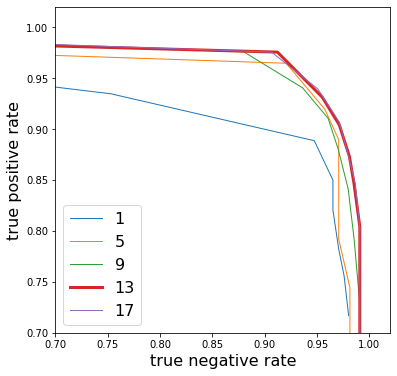

In [65]:
figure(figsize=(6,6))
xlim(0.7,1.02)
ylim(0.7,1.02)
# plot(tn_AB_avg, tp_AB_avg,linewidth=3)
plot(tn_bagging_kernel[0], tp_bagging_kernel[0],linewidth=1)
plot(tn_bagging_kernel[1], tp_bagging_kernel[1],linewidth=1)
plot(tn_bagging_kernel[2], tp_bagging_kernel[2],linewidth=1)
plot(tn_bagging_kernel[3], tp_bagging_kernel[3],linewidth=3)
plot(tn_bagging_kernel[4], tp_bagging_kernel[4],linewidth=1)
legend(['1','5','9','13','17'],fontsize=16)
xlabel('true negative rate',fontsize=16)
ylabel('true positive rate',fontsize=16)
title("Various T with r=0.3")

choose T = 13

# Adaboost Hyperparameter Search

In [70]:
tp_adaboost = []
tn_adaboost = []

for t in np.arange(1,22,4):
    tp_adaboost_tmp = []
    tn_adaboost_tmp = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        tp, tn = opt_linear_adaboost(X_train, X_test, y_train, y_test, T=t, lr=0.5, sparse_ratio=0.7)
        tp_adaboost_tmp.append(tp)
        tn_adaboost_tmp.append(tn)
    tp_adaboost_tmp_avg = np.average(np.array(tp_adaboost_tmp), axis=0)
    tn_adaboost_tmp_avg = np.average(np.array(tn_adaboost_tmp), axis=0)
    tp_adaboost.append(tp_adaboost_tmp_avg)
    tn_adaboost.append(tn_adaboost_tmp_avg)

Done


Text(0, 0.5, 'true positive rate')

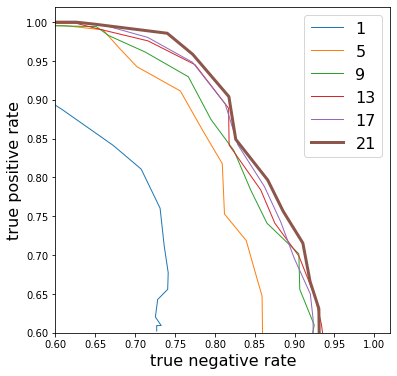

In [73]:
figure(figsize=(6,6))
xlim(0.6,1.02)
ylim(0.6,1.02)
# plot(tn_AB_avg, tp_AB_avg,linewidth=3)
plot(tn_adaboost[0], tp_adaboost[0],linewidth=1)
plot(tn_adaboost[1], tp_adaboost[1],linewidth=1)
plot(tn_adaboost[2], tp_adaboost[2],linewidth=1)
plot(tn_adaboost[3], tp_adaboost[3],linewidth=1)
plot(tn_adaboost[4], tp_adaboost[4],linewidth=1)
plot(tn_adaboost[5], tp_adaboost[5],linewidth=3)
legend(['1','5','9','13','17','21'],fontsize=16)
xlabel('true negative rate',fontsize=16)
ylabel('true positive rate',fontsize=16)

choose T=21

In [76]:
tp_adaboost = []
tn_adaboost = []

for u in np.arange(0.1,0.99,0.2):
    tp_adaboost_tmp = []
    tn_adaboost_tmp = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        tp, tn = opt_linear_adaboost(X_train, X_test, y_train, y_test, T=21, lr=0.5, sparse_ratio=u)
        tp_adaboost_tmp.append(tp)
        tn_adaboost_tmp.append(tn)
    tp_adaboost_tmp_avg = np.average(np.array(tp_adaboost_tmp), axis=0)
    tn_adaboost_tmp_avg = np.average(np.array(tn_adaboost_tmp), axis=0)
    tp_adaboost.append(tp_adaboost_tmp_avg)
    tn_adaboost.append(tn_adaboost_tmp_avg)

Done


Text(0.5, 1.0, 'Various sparse_ratio u with T=21')

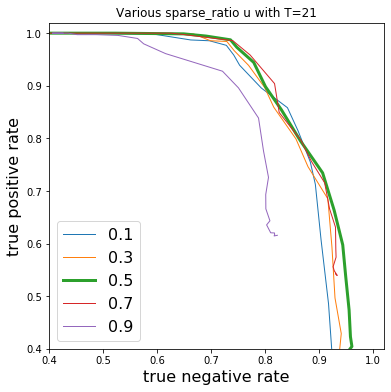

In [86]:
figure(figsize=(6,6))
xlim(0.4,1.02)
ylim(0.4,1.02)
# plot(tn_AB_avg, tp_AB_avg,linewidth=3)
plot(tn_adaboost[0], tp_adaboost[0],linewidth=1)
plot(tn_adaboost[1], tp_adaboost[1],linewidth=1)
plot(tn_adaboost[2], tp_adaboost[2],linewidth=3)
plot(tn_adaboost[3], tp_adaboost[3],linewidth=1)
plot(tn_adaboost[4], tp_adaboost[4],linewidth=1)
legend(['0.1','0.3','0.5','0.7','0.9'],fontsize=16)
xlabel('true negative rate',fontsize=16)
ylabel('true positive rate',fontsize=16)
title("Various sparse_ratio u with T=21")

choose u=0.5